In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import stan
import nest_asyncio
import arviz as az
from matplotlib.backends.backend_pdf import PdfPages

nest_asyncio.apply()
plt.ion()

DATA_DIR = "./Data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv"

df = pd.read_csv(DATA_DIR) 

df = df.iloc[:, :17]  # Drop all the flag

# Sep: Soc nhiem khuan
# Malignant: Khoi u ac tinh
# Diabete: Tieu duong
# Alzheimer: Mat tri nho
# Influenze: Cum - Viem phoi
# Chronic: Nhiem trung duong ho hap duoi man tinh
# Other: nhung benh duong ho hap khac
# Nephristic: Viem than, than hu -> co qua nhieu protein trong nuoc tieu, benh than ma ko co viem nhiem
# Symtoms: Ket qua bat thuong nhung chua dc define
# Diseases of heart: tim co vn de
# Cerebrovascular: Mach mau toi tim, tim len nao
# Visualization
sns.set_theme()


# for x in df.columns[5:]:
#     df[x] = df[x] / df["All  Cause"]

Since the amount of data for this problem is quite high compared to the model selected. As a result, weakly informative prior
has been chosen for each model.

In [54]:
## Natural Cause

# Read in each model

with open("natural_cause.stan", "r") as my_file:
    all_models = my_file.read()

pool_model,separate_model=   all_models.split("//---")

# Setup data for each model.

# Pool
n_pool = df.shape[0]
df_natural_cause = df[["All  Cause", "Natural Cause"]]
x_pool = df_natural_cause['All  Cause'].values
y_pool = df_natural_cause['Natural Cause'].values
data_pool = {'n': n_pool, 'x': x_pool, 'y': y_pool}

# Separate, Hierarchical
x_sep_df = pd.DataFrame(columns= df["Jurisdiction of Occurrence"].unique())
y_sep_df = pd.DataFrame(columns= df["Jurisdiction of Occurrence"].unique())
for (state, group) in df.groupby(by="Jurisdiction of Occurrence")["All  Cause"]:
    x_sep_df[state] = group.values
for (state, group) in df.groupby(by="Jurisdiction of Occurrence")["Natural Cause"]:
    y_sep_df[state] = group.values
x_sep = x_sep_df.T.values
y_sep = y_sep_df.T.values
groups_nof = df["Jurisdiction of Occurrence"].unique().shape[0]
n_sep = 313
data_sep = {'g': groups_nof, 'n': n_sep, 'x': x_sep, 'y': y_sep}

# Pool model:

posterior_pool = stan.build(pool_model, data = data_pool);
fit_pool = posterior_pool.sample(num_chains= 4, num_samples = 1000);
df_pool = fit_pool.to_frame()

# Separate model:

posterior_sep = stan.build(separate_model, data = data_sep);
fit_sep = posterior_sep.sample(num_chains= 4, num_samples = 1000);
df_sep = fit_sep.to_frame()


Building...



Building: found in cache, done.Sampling:   0%
Sampling:   5% (400/8000)
Sampling:  12% (1000/8000)
Sampling:  21% (1700/8000)
Sampling:  46% (3700/8000)
Sampling:  66% (5300/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000102 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000102 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000146 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.46 seconds.
  Adjust your expecta

In [55]:
print('----')
print()
print()
print(df_pool.head(5))
print('----')
print()
print()
print(df_sep.head(5))


----


parameters          lp__  accept_stat__  stepsize__  treedepth__  \
draws                                                              
0          -9.633226e+06       0.916376    0.179802          1.0   
1          -9.633227e+06       0.453595    0.255256          2.0   
2          -9.633227e+06       0.813668    0.188134          1.0   
3          -9.633226e+06       1.000000    0.170559          1.0   
4          -9.633226e+06       0.998342    0.179802          2.0   

parameters  n_leapfrog__  divergent__      energy__     theta  ypred.1  \
draws                                                                    
0                    3.0          0.0  9.633229e+06  0.915824   3065.0   
1                    3.0          0.0  9.633229e+06  0.915780   3105.0   
2                    3.0          0.0  9.633228e+06  0.915897   3079.0   
3                    1.0          0.0  9.633226e+06  0.915839   3084.0   
4                    3.0          0.0  9.633226e+06  0.915829   3095.0  

## Validating a Fit in Stan

Convergence checking

In [6]:
# Checking split R and ess.

print(az.summary(fit_pool))

# BFMI quantifies how well momentum resampling matches the marginal energy distribution. 
# For more information on BFMI, see https://arxiv.org/pdf/1604.00695v1.pdf. 
# The current advice is that values smaller than 0.3 indicate poor sampling. 
# However, this threshold is provisional and may change. 
# See pystan_workflow for more information.
print(az.bfmi(fit_pool))  # Smaller than 0.3 indicate poor sampling


                  mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
theta            0.916   0.000     0.916     0.916      0.000    0.000   
ypred[0]      3096.920  16.274  3066.000  3126.000      0.254    0.180   
ypred[1]      3205.842  16.657  3173.000  3235.000      0.261    0.184   
ypred[2]      3339.422  16.863  3305.000  3369.000      0.278    0.197   
ypred[3]      3310.895  16.788  3278.000  3340.000      0.268    0.189   
...                ...     ...       ...       ...        ...      ...   
ypred[16897]   566.824   6.894   552.000   578.000      0.109    0.077   
ypred[16898]   508.095   6.568   495.000   519.000      0.104    0.073   
ypred[16899]   481.759   6.445   470.000   493.000      0.102    0.072   
ypred[16900]   528.367   6.618   517.000   541.000      0.109    0.077   
ypred[16901]   506.558   6.491   494.000   518.000      0.106    0.075   

              ess_bulk  ess_tail  r_hat  
theta           1535.0    1925.0    1.0  
ypred[0]        4112.0    3

## Posterior predictive check

- Visualization
  - pdf, cdf
  - marginal and CV prdictive checking 
  - Probability integral transform


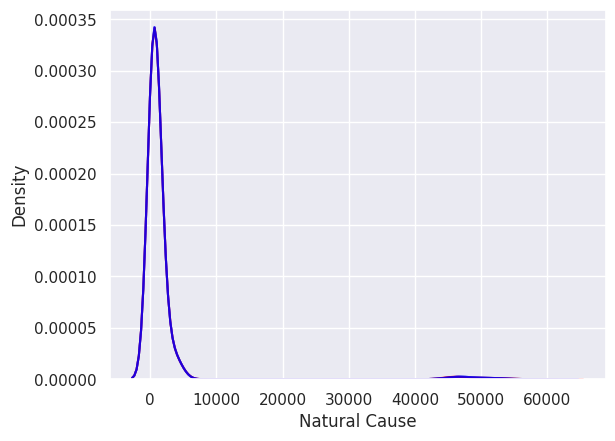

In [56]:
# Pool model.

ypred_df_pool = df_pool[['ypred.{}'.format(x) for x in range(1, n_pool+1)]].T.reset_index().drop(columns= "parameters")
fig, ax = plt.subplots()
fig.set_label("Pool model")
sns.kdeplot(df, x = "Natural Cause", ax = ax, color="red")
for i in range(1,10):
    sns.kdeplot(ypred_df_pool[i], ax = ax, color = 'blue', alpha = 0.2)


In [57]:
# Separate model

pp = PdfPages('sep_predictive_check.pdf')
states = x_sep_df.columns
ypred_df_sep = df_sep[['ypred.{}.{}'.format(x,y) for x in range(1,groups_nof+1) for y in range(1,n_sep + 1)]].T

for j in range(0,54):
    fig, ax = plt.subplots()
    sns.kdeplot(df[df['Jurisdiction of Occurrence'] == states[j]], x = "Natural Cause", ax = ax, color="red")
    mask = ['ypred.{}.{}'.format(j+1,x) for x in range(1, n_sep + 1) ]
    for i in range(1,10):
        sns.kdeplot(ypred_df_sep.loc[mask, i], ax = ax, color = 'blue', alpha = 0.2)
    pp.savefig(fig)
    plt.close(fig)
pp.close()

## Predictive assessment (optional)

- Error
- Usefulness

## Sensitive anlysis
- Pool model: Since we expect that the natural cause should be higher than unnatural one. We could try 2 sensitive analysis prior for theta.

  - False informative: Beta(2,11)
  - Inofrmative: Beta(8,4)\

  

- Separate model

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0495vv9v/model_6cbk2ocl.stan', line 11, column 19: Argument
    11 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   5% (400/8000)
Sampling:  12% (1000/8000)
Sampling:  20% (1600/8000)
Sampling:  45% (3600/8000)
Sampling:  65% (5200/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00018 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.8 second

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  16% (1300/8000)
Sampling:  41% (3300/8000)
Sampling:  66% (5300/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 9.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
  Adjust your expectations accordingly!


<AxesSubplot: xlabel='theta', ylabel='Density'>

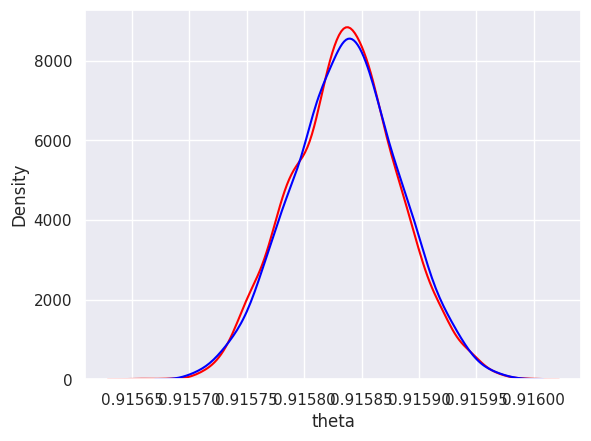

In [14]:
## Pool model

# Stan code:

f_inf_pool = """
data {
    int<lower=0> n;
    array[n] int x;
    array[n] int y;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(2,11);
    y ~ binomial(x, theta);
}
"""
inf_pool = """
data {
    int<lower=0> n;
    array[n] int x;
    array[n] int y;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(8,4);
    y ~ binomial(x, theta);
}
"""

post_f_inf_pool = stan.build(f_inf_pool, data = data_pool);
fit_f_inf_pool = post_f_inf_pool.sample(num_chains= 4, num_samples = 1000);
df_f_inf_pool = fit_f_inf_pool.to_frame()

post_inf_pool = stan.build(inf_pool, data = data_pool);
fit_inf_pool = post_inf_pool.sample(num_chains= 4, num_samples = 1000);
df_inf_pool = fit_inf_pool.to_frame()

# Plot theta from two models:

fig, axes = plt.subplots()
sns.kdeplot(df_f_inf_pool['theta'], ax = axes, color = 'red')
sns.kdeplot(df_inf_pool['theta'], ax = axes, color = 'blue')

In [ ]:
# Separate model

# Stan code:

f_inf_pool = """
data {
    int<lower=0> n;
    array[n] int x;
    array[n] int y;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(2,11);
    y ~ binomial(x, theta);
}
"""
inf_pool = """
data {
    int<lower=0> n;
    array[n] int x;
    array[n] int y;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(8,4);
    y ~ binomial(x, theta);
}
"""

post_f_inf_pool = stan.build(f_inf_pool, data = data_pool);
fit_f_inf_pool = post_f_inf_pool.sample(num_chains= 4, num_samples = 1000);
df_f_inf_pool = fit_f_inf_pool.to_frame()

post_inf_pool = stan.build(inf_pool, data = data_pool);
fit_inf_pool = post_inf_pool.sample(num_chains= 4, num_samples = 1000);
df_inf_pool = fit_inf_pool.to_frame()

# Plot theta from two models:

fig, axes = plt.subplots()
sns.kdeplot(df_f_inf_pool['theta'], ax = axes, color = 'red')
sns.kdeplot(df_inf_pool['theta'], ax = axes, color = 'blue')

## Model comparision and selection
- This could be done by loo or k-fold cross validation